In [3]:
import numpy as np
#import skimage as ski
from skimage import io
import cv2 as cv
import math
from pylab import *
%matplotlib inline

def Bresenham(img, x1, y1, x2, y2, avg):
    if(x1 <= x2): kx = 1
    else: kx = -1
    if(y1 <= y2): ky = 1
    else: ky = -1
        
    if(x1 >= len(img[0,:])): x1 = x1 - (x1 - len(img[0,:])) - 1
    if(x2 >= len(img[0,:])): x2 = x2 - (x2 - len(img[0,:])) - 1
    if(y1 >= len(img[:,0])): y1 = y1 - (y1 - len(img[:,0])) - 1
    if(y2 >= len(img[:,0])): y2 = y2 - (y2 - len(img[:,0])) - 1
    
    s = 0
        
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    s = img[x1,y1]
    avg[x1,y1] += 1
    #img[y1,x1] = 0.5
    
    if(dx >= dy):
        e = dx / 2
        for i in range(0, dx):
            x1 = x1 + kx
            e = e - dy
            if(e < 0):
                y1 = y1 + ky
                e = e + dx  
            s = s + img[x1,y1]
            avg[x1,y1] += 1
            #img[y1,x1] = 0.5
        return s / dx
    else:
        e = dy / 2
        for i in range(0, dy):
            y1 = y1 + ky
            e = e - dx
            if(e < 0):
                x1 = x1 + kx
                e = e + dy
            s = s + img[x1,y1]
            avg[x1,y1] += 1
        return s / dy
    
def BresenhamInv(img, x1, y1, x2, y2, colour):
    if(x1 <= x2): kx = 1
    else: kx = -1
    if(y1 <= y2): ky = 1
    else: ky = -1
        
    if(x1 >= len(img[0,:])): x1 = x1 - (x1 - len(img[0,:])) - 1
    if(x2 >= len(img[0,:])): x2 = x2 - (x2 - len(img[0,:])) - 1
    if(y1 >= len(img[:,0])): y1 = y1 - (y1 - len(img[:,0])) - 1
    if(y2 >= len(img[:,0])): y2 = y2 - (y2 - len(img[:,0])) - 1
        
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    if(dx >= dy):
        colour = colour / dx
    else:
        colour = colour / dy
    img[x1,y1] = img[x1, y1] + colour
    
    if(dx >= dy):
        e = dx / 2
        for i in range(0, dx):
            x1 = x1 + kx
            e = e - dy
            if(e < 0):
                y1 = y1 + ky
                e = e + dx  
            img[x1,y1] = img[x1,y1] + colour
        return
    else:
        e = dy / 2
        for i in range(0, dy):
            y1 = y1 + ky
            e = e - dx
            if(e < 0):
                x1 = x1 + kx
                e = e + dy
            img[x1,y1] = img[x1,y1] + colour
        return
    
def normalize(img):
    width = len(img[0,:])
    height = len(img[:,0])
    maks = 0
    mini = 1000000
    for i in range(height):
        temp = max(img[i,:])
        if(temp > maks):
            maks = temp
        temp = min(img[i,:])
        if(temp < mini):
            mini = temp
    return ( (img - mini) / (maks - mini) ) * 255
    
def normalizeToOne(img):
    width = len(img[0,:])
    height = len(img[:,0])
    maks = 0
    mini = 1000000
    for i in range(height):
        temp = max(img[i,:])
        if(temp > maks):
            maks = temp
        temp = min(img[i,:])
        if(temp < mini):
            mini = temp
    return ( (img - mini) / (maks - mini) )

def normalize2(img):
    maks = 0
    mini = 10000000
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(img[i,j] > maks):
                maks = img[i,j]
            if((img[i,j] < mini) and (img[i,j] > 0)):
                mini = img[i,j]
    return ( (img - mini) / (maks - mini) ) * 255

def averaging(img, med):
    for i in range(len(img[:,0])):
        for j in range(len(img[0,:])):
            img[i,j] = img[i,j] / med[i,j]
            
def contrast(img):
    temp = normalizeToOne(img)
    temp = temp ** 0.5;
    return normalize(temp)

def convolution(img):
    k = 10
    n = 2*k + 1
    fr = np.zeros(n)
    fr[k] = 1
    for i in np.arange(1,k+1,2):
        fr[k + i] = -4 / (pi*pi*i*i)
        fr[k - i] = -4 / (pi*pi*i*i)
    width = img.shape[1]
    con = np.zeros((img.shape[0],img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            sums = img[i,j]
            for x in range(1,k+1):
                if(j-x >= 0):
                    sums += img[i,j-x]*fr[k-x]
                if(j+x < width):
                    sums += img[i,j+x]*fr[k+x]
            con[i,j] = sums
            
    return con


In [4]:
##DICOM function
import pydicom
from pydicom.dataset import Dataset, FileDataset
import numpy as np
import datetime
from skimage import *
import matplotlib.pyplot as plt
from pydicom.misc import is_dicom

def saveDicom(image,fileName='nowa',patientName='',patientID='',patientSex='',patientAge=''
              ,comments='', dateTime=datetime.datetime.now()):
    
    
    fileName+='.dcm'
    pixel_array = img_as_uint(image)

    ds = Dataset()
    file_meta = Dataset()
    file_meta.MediaStorageSOPClassUID = 'Secondary Capture Image Storage'
    file_meta.MediaStorageSOPInstanceUID = '1.3.6.1.4.1.9590.100.1.1.111165684411017669021768385720736873780'
    file_meta.ImplementationClassUID = '1.3.6.1.4.1.9590.100.1.0.100.4.0'
    file_meta.TransferSyntaxUID = '1.2.840.10008.1.2'
    
    ds = FileDataset(fileName, {},file_meta=file_meta, preamble=b"\0" * 128)


    ##dane pacjenta i opis
    ds.PatientName = patientName
    ds.PatientID = patientID
    ds.PatientSex = patientSex
    ds.PatientAge = patientAge
    ds.ImageComments = comments
    ds.Modality ='CT'


    #data badania
    ds.ContentDate = dateTime.strftime('%Y-%m-%d')
    ds.ContentTime = dateTime.strftime('%H:%M')

    ds.SOPClassUID = '1.2.840.10008.5.1.4.1.1.2' 


    ds.SamplesPerPixel = 1
    ds.PlanarConfiguration = 0
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0
    ds.HighBit = 15
    ds.BitsStored =16
    ds.BitsAllocated = 16

    if pixel_array.dtype != np.uint16:
        pixel_array = pixel_array.astype(np.uint16)
    ds.SmallestImagePixelValue = pixel_array.min()
    ds.LargestImagePixelValue = pixel_array.max()

    ds.PixelData = pixel_array.tobytes()
    ds.Rows, ds.Columns = pixel_array.shape
    ds.Width, ds.Height = pixel_array.shape


    ds.save_as(fileName)

def readDICOM(image_path, cmap='gray'):   
    if is_dicom(image_path):
        ds = pydicom.dcmread(image_path)
        plt.figure(dpi=200)
        plt.imshow(ds.pixel_array, cmap= cmap)
        plt.show()
        #print(ds.PatientID)
    else: 
        print("It's probably not DICOM")

In [5]:
def tomography(file='./zdjecia/Shepp_logan2.jpg', angSt=1, rotAng=360, detNum=300, detAng=300):
    #angleStep = 1
    #rotationAngle = 360
    angleStep = angSt
    rotationAngle = rotAng
    iterations = int(rotationAngle / angleStep)
    #detectorsNumber = 600
    detectorsNumber = detNum
    detectorsNumbern = detectorsNumber-1
    #detectorsAngle = 300
    detectorsAngle = detAng
    detectorsAngleh = detectorsAngle/2
    detectorsAngleStep = detectorsNumber / detectorsAngle

    image = io.imread(file, as_gray=True)
    image = normalize(image)

    width = len(image[0,:])
    height = len(image[:,0])
    radius = 0
    
    if (width > height):
        w2 = math.floor((width - height) / 2)
        imgTemp = np.zeros((width,width))
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                imgTemp[i+w2,j] = image[i,j]
        image = imgTemp
    elif (height > width):
        h2 = math.floor((height - width) / 2)
        imgTemp = np.zeros((height,height))
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                imgTemp[i,j+h2] = image[i,j]
        image = imgTemp
        
    width = len(image[0,:])
    height = len(image[:,0])
    radius = 0

    if (width > height):
        radius = math.floor(height / 2)
    else:
        radius = math.floor(width / 2)
        
    centerPoint = radius

    avg = np.ones((height,width))
    sinograph = np.zeros((int(rotationAngle/angleStep), int(detectorsNumber)))
    print("Tworzenie sinogramu...")
    
    ri = 0
    while (ri < iterations):
        rit = ri*angleStep
        startx = round(centerPoint + radius*np.cos(radians(rit)))
        starty = round(centerPoint + radius*np.sin(radians(rit)))

        di = 0
        while(di < detectorsNumber):
            endx = round(centerPoint + radius*np.cos(radians( rit+180-(detectorsAngleh)+(di*detectorsAngle/(detectorsNumbern)) )))
            endy = round(centerPoint + radius*np.sin(radians( rit+180-(detectorsAngleh)+(di*detectorsAngle/(detectorsNumbern)) )))

            sinograph[ri,di] = Bresenham(image, int(startx), int(starty), int(endx), int(endy), avg)
            di = di + 1
        ri = ri + 1

    print("Zrobiono sinograf")
    plt.imshow(sinograph, cmap='gray')
    plt.show()

    sinograph2 = convolution(sinograph)
    
    print("Sinograf po splocie")
    plt.imshow(sinograph2, cmap='gray')
    plt.show()

    imgParts = []
    print("Trwa rekonstrukcja obrazu...")

    invImage = np.zeros((len(image[:,0]), len(image[0,:])))
    invImage2 = np.zeros((len(image[:,0]), len(image[0,:])))
    for ri in range(len(sinograph[:,0])):
        rit = ri*angleStep
        startx = round(centerPoint + radius*np.cos(radians(rit)))
        starty = round(centerPoint + radius*np.sin(radians(rit)))
        for di in range(len(sinograph[0,:])):
            endx = round(centerPoint + radius*np.cos(radians( rit+180-(detectorsAngleh)+(di*detectorsAngle/(detectorsNumbern)) )))
            endy = round(centerPoint + radius*np.sin(radians( rit+180-(detectorsAngleh)+(di*detectorsAngle/(detectorsNumbern)) )))
            #BresenhamInv(invImage, int(startx), int(starty), int(endx), int(endy), sinograph[ri,di])
            BresenhamInv(invImage2, int(startx), int(starty), int(endx), int(endy), sinograph2[ri,di])
        if (ri % 5 == 0):
            imgParts.append(invImage2.copy())

    imgParts.append(invImage2.copy())
    
    
    #invImage221 = contrast(invImage2)
    #cv.imwrite("reconstructed_wo_avg_con.jpg",invImage221)

    #invImage = normalize(invImage)
    invImage222 = normalize2(invImage2)
    cv.imwrite('reconstructed1.jpg',invImage222)#####zapisywanie przez cv

    averaging(invImage2, avg)


    invImage22 = normalize2(invImage2)
    cv.imwrite("reconstructed.jpg",invImage22) #####zapisywanie przez cv
    
    #invImage2 = normalizeToOne(invImage2)
#     plt.imsave("rec_plt.jpg",invImage22, cmap='gray')#####zapisywanie przez plt

    plt.imshow(invImage2, cmap='gray')
    #plt.imshow(invImage22, cmap='gray')
    plt.show()
    return invImage2, imgParts


Tworzenie sinogramu...
Zrobiono sinograf


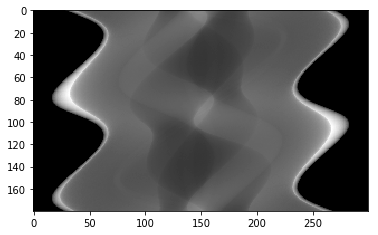

Sinograf po splocie


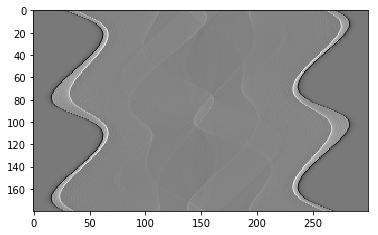

Trwa rekonstrukcja obrazu...


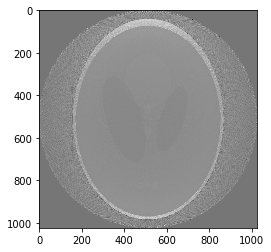

interactive(children=(IntSlider(value=0, description='zdjecie', max=36), Output()), _dom_classes=('widget-inte…

In [6]:
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Label, interact, interactive
from IPython.display import display, clear_output
 
   
fileText = widgets.Text(
    value = './zdjecia/Shepp_logan2.jpg',
    #description = 'Ścieżka do pliku:',
    #layout=widgets.Layout(width='600px'),
    #style = {'description_width': 'initial'}
)
    
angStepFloat = widgets.BoundedFloatText(
    value = 2,
    #description = 'Krok emitera:',
    min = 0.1,
    max = 360,
    #layout=widgets.Layout(width='600px'),
    #style = {'description_width': 'initial'}
    #step = 0.5
)

detNumInt = widgets.BoundedIntText(
    value = 300,
    #description = 'Liczba detektorów:',
    min = 1,
    max = 1000,
    #layout=widgets.Layout(width='600px'),
    #style = {'description_width': 'initial'}
)

detAngInt = widgets.BoundedIntText(
    value = 300,
    #description = 'Rozpiętość detektorów:',
    min = 1,
    max = 360,
    #layout=widgets.Layout(width='600px'),
    #style = {'description_width': 'initial'}
)

but = widgets.Button(
    description='Wykonaj',
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Wykonaj',
    #layout=widgets.Layout(flex='1', align_self='center')
)

@but.on_click
def fun(b):
    wykonaj()
    
    
def wykonaj(b=None):
    #def tomography(file='./zdjecia/Shepp_logan2.jpg', angSt=1, rotAng=360, detNum=300, detAng=300):
    #tomography(fileText.value, angStepFloat.value, 360, detNumInt.value, detAngInt.value)
    clear_output()
    display(hhhbox)
    global image
    global imgParts
    image, imgParts = tomography(fileText.value, angStepFloat.value, 360, detNumInt.value, detAngInt.value)
    
    def fff(zdjecie):
        figure(figsize=(10,10))
        plt.imshow(imgParts[zdjecie], cmap='gray')
        plt.show()
    
    interactive_plot = interact(fff, zdjecie=widgets.IntSlider(min=0,max=len(imgParts)-1,step=1,value=0))
    interactive_plot

image = [] 
words = [Label('Ścieżka do pliku:'), Label('Krok emitera:'), Label('Liczba detektorów:'), Label('Rozpiętość detektorów:')]
leftbox = widgets.VBox(words)
rightbox = widgets.VBox(children=[fileText, angStepFloat, detNumInt, detAngInt, but])
hhhbox = HBox([leftbox,rightbox])
display(hhhbox)

In [7]:
fileText2 = widgets.Text(
    value = '',
    description = 'Nazwa pliku:',
)

name = widgets.Text(
    value = '',
    description = 'Pacjent:',
)

patientID = widgets.Text(
    value = '',
    description = 'ID pacjetna:',
)

patientSex = widgets.Text(
    value = '',
    description = 'Płeć:',
)

patientAge = widgets.Text(
    value = '',
    description = 'Wiek:',
)

comments = widgets.Text(
    value = '',
    description = 'Komentarze:',
)

date = widgets.Text(
    value = '1986-01-04',
    description = 'Data badania:',
)

button = widgets.Button(description='Zapisz')

print('Zapisywanie pliku DICOM')

display(fileText2,name,patientID,patientSex,patientAge,comments,date,button)


def save(button_object):
        if(fileText2.value!=''):
            img = image
            if len(img) > 0:
                if(img.max()> abs(img.min())):
                    img = img/img.max()
                else:
                    img = img/abs(img.min())
                saveDicom(img,fileName=fileText2.value,patientName=name.value,patientID=patientID.value,patientSex=patientSex.value
                          ,patientAge=patientAge.value,comments=comments.value, dateTime=datetime.datetime.strptime(date.value,'%Y-%m-%d'))
            else:
                print("Musisz najpierw wykonać tomografię.")
        else:
            print("Podaj nazwe pliku!")
            #print(datetime.datetime.strptime(date.value,'%Y-%m-%d').dtype)
button.on_click(save)


Zapisywanie pliku DICOM


Text(value='', description='Nazwa pliku:')

Text(value='', description='Pacjent:')

Text(value='', description='ID pacjetna:')

Text(value='', description='Płeć:')

Text(value='', description='Wiek:')

Text(value='', description='Komentarze:')

Text(value='1986-01-04', description='Data badania:')

Button(description='Zapisz', style=ButtonStyle())

In [8]:
fileTextr = widgets.Text(
    value = './nowy.dcm',
    description = 'Scieżka do pliku:',
)

button = widgets.Button(description='Odczytaj')

print('Odczytywanie pliku DICOM')

display(fileTextr,button)


def read(button_object):
        clear_output()
        print('Odczytywanie pliku DICOM')
        display(fileTextr,button)
        if(fileTextr.value!=''):
            readDICOM(fileTextr.value)
        else:
            print("Podaj ścieżke do pliku!")
button.on_click(read)


Odczytywanie pliku DICOM


Text(value='./nowy.dcm', description='Scieżka do pliku:')

Button(description='Odczytaj', style=ButtonStyle())

In [10]:
def rmse(file1, file2):
    img = io.imread(file1, as_gray=True)
    res = io.imread(file2, as_gray=True)
    img = normalize(img)
    res = normalize(res)
    s = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            s += (img[i,j]-res[i,j])*(img[i,j]-res[i,j])
    return math.sqrt(s / (img.shape[0]*img.shape[1]))

# rmse('./zdjecia/CT_ScoutView-large.jpg', './reconstructed.jpg')   